# Questions

1. могу ли я сделать видео визуализацию по картинкой головы. То есть чтобы было видео как сигнал меняется со временем по голове.
2. Есть ли какая-то проверка на линейнную зависимость каналов


MNE continuous data working

# Import libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt

import mne
mne.set_log_level('error')


import os
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.options.display.max_columns = None # показываем все колонки

# Distinguishing dataset



**Dataset:** [EEG data for Mental Attention State Detection](
https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data)

**Article:** [Distinguishing mental attention states of humans via an EEG-based passive BCI using machine learning methods](https://sci-hub.ru/10.1016/j.eswa.2019.05.057)


Маркировка засчет того что известна сложность маршрута между: focused, unfocused,drowsy


## Reading files

In [ ]:
data_path = 'datasets\\Distinguishing\\'

eeg_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

sfreq = 128
voltage_resolution = 0.51e-6

distinguishing_data = {}


for file_index in range(1, 35):  # от 1 до 34 включительно
    file_name = f'eeg_record{file_index}.mat'
    file_path = os.path.join(data_path, file_name)

    if not os.path.exists(file_path):
        print(f"Файл не найден, пропускаю: {file_name}")
        continue

    # Вычисляем участника и день
    participant_id = min((file_index - 1) // 7 + 1, 5)
    participant_key = f'participant_{participant_id}'

    day_id = (file_index - 1) % 7 + 1
    day_key = f'day_{day_id}'

    # Создаём словарь участника, если он ещё не существует
    if participant_key not in distinguishing_data:
        distinguishing_data[participant_key] = {}

    # Загрузка и обработка данных
    mat_data = scipy.io.loadmat(file_path)
    data = mat_data['o'][0][0]['data']
    eeg_data = pd.DataFrame(data).iloc[:, 4:18].to_numpy().T


    scaled_data = eeg_data * voltage_resolution

    info = mne.create_info(
        ch_names=eeg_channels, 
        sfreq=sfreq, 
        ch_types=['eeg'] * len(eeg_channels)
    )
    raw = mne.io.RawArray(scaled_data, info)
    raw.set_montage('standard_1020')

    # Обрезаем до 20 мин, если меньше не трогаем
    raw.crop(tmax=20 * 60)

    # Добавляем в структуру
    distinguishing_data[participant_key][day_key] = raw

    print(f'Файл {file_name} загружен → {participant_key}|{day_key} ✅ ')

Файл eeg_record1.mat загружен → participant_1|day_1 ✅ 
Файл eeg_record2.mat загружен → participant_1|day_2 ✅ 
Файл eeg_record3.mat загружен → participant_1|day_3 ✅ 
Файл eeg_record4.mat загружен → participant_1|day_4 ✅ 
Файл eeg_record5.mat загружен → participant_1|day_5 ✅ 
Файл eeg_record6.mat загружен → participant_1|day_6 ✅ 
Файл eeg_record7.mat загружен → participant_1|day_7 ✅ 
Файл eeg_record8.mat загружен → participant_2|day_1 ✅ 
Файл eeg_record9.mat загружен → participant_2|day_2 ✅ 
Файл eeg_record10.mat загружен → participant_2|day_3 ✅ 
Файл eeg_record11.mat загружен → participant_2|day_4 ✅ 
Файл eeg_record12.mat загружен → participant_2|day_5 ✅ 
Файл eeg_record13.mat загружен → participant_2|day_6 ✅ 
Файл eeg_record14.mat загружен → participant_2|day_7 ✅ 
Файл eeg_record15.mat загружен → participant_3|day_1 ✅ 
Файл eeg_record16.mat загружен → participant_3|day_2 ✅ 
Файл eeg_record17.mat загружен → participant_3|day_3 ✅ 
Файл eeg_record18.mat загружен → participant_3|day_4 ✅ 
Ф

In [ ]:
distinguishing_data['participant_1']['day_1']

<RawArray | 14 x 153601 (1200.0 s), ~16.4 MiB, data loaded>

## Merging files/ MNE events/ Metadata

In [ ]:
raw_objects = []
events = []
metadata = []

for participant_key in sorted(distinguishing_data.keys()):
    for day_key in sorted(distinguishing_data[participant_key].keys()):
        raw = distinguishing_data[participant_key][day_key].pick_channels(['F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'])

        raw_objects.append(raw)

        # focused: первые 10 минут (600 сек)
        focused_events = mne.make_fixed_length_events(
            raw,
            id=1,
            start=0,
            stop=600,
            duration=0.25,
            overlap=0.0
        )

        # unfocused: вторые 10 минут (600–1200 сек)
        unfocused_events = mne.make_fixed_length_events(
            raw,
            id=0,
            start=600,
            stop=1200,
            duration=0.25,
            overlap=0.0
        )

        # объединяем события для этого файла
        events_one = np.vstack([focused_events, unfocused_events])
        events.append(events_one)

        # создаем metadata (только subject и session)
        meta_one = pd.DataFrame({
            "subject": [participant_key] * len(events_one),
            "session": [day_key] * len(events_one)
        })
        metadata.append(meta_one)


# Raw
raw_objects = [raw_objects[0].copy()] + raw_objects[1:]
first_samps = [r.first_samp for r in raw_objects]
last_samps  = [r.last_samp for r in raw_objects]

distinguishing_full = mne.concatenate_raws(raw_objects)

# Events
event_dict = {
    'focused': 1,
    'unfocused': 0
}
events = mne.concatenate_events(events, first_samps, last_samps)

# Metadata
metadata = pd.concat(metadata, ignore_index=True)


### Events plot

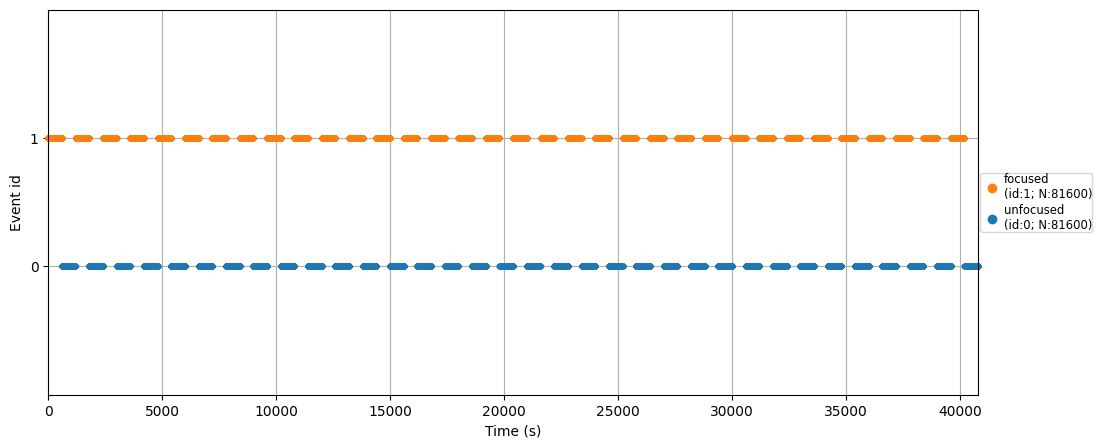

In [ ]:

fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    events,
    distinguishing_full.info["sfreq"],
    event_id=event_dict,
    axes=ax
)


## Preprocessing

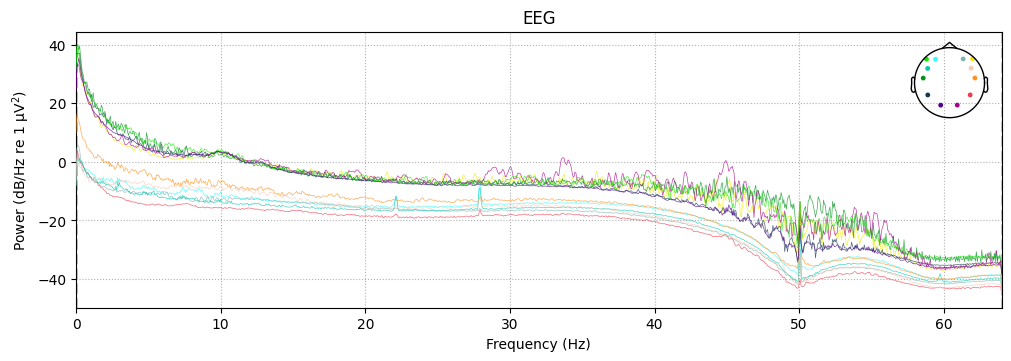

In [ ]:
distinguishing_full.compute_psd().plot()

In [ ]:
# Artifact removal with ICA

notch_freqs = [50]
ica_l = 1.0
ica_h = 45.0

raw_for_ica = distinguishing_full.copy()
raw_for_ica.notch_filter(freqs=notch_freqs) # Notch filter
raw_for_ica.filter(l_freq=ica_l, h_freq=ica_h) # Bandpass filter specially for ICA

ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
ica.fit(raw_for_ica)

In [ ]:
ica.plot_components()

In [ ]:
max_ic = 2       # Максимальное число EOG-компонент, которые можно исключить
z_thresh = 2.4   # Начальный Z-порог
z_step = 0.05    # Шаг уменьшения порога

num_excl = 0
final_indices = []

while num_excl < max_ic and z_thresh > 0:
    eog_indices, eog_scores = ica.find_bads_eog(
        raw_for_ica,  # или epochs
        ch_name=['F3', 'F4', 'F7', 'F8'],
        threshold=z_thresh
    )
    num_excl = len(eog_indices)
    final_indices = eog_indices

    if num_excl < max_ic:
        z_thresh -= z_step
    else:
        break

# Назначаем найденные индексы для удаления
ica.exclude = final_indices


# Применяем
ica.apply(distinguishing_full)

print(f"Final Z-threshold = {z_thresh:.2f}")
print(f"Components to exclude: {ica.exclude}")


In [ ]:
# Filtering
final_l = 0.01
final_h  = 43

distinguishing_full.filter(final_l, final_h)

<RawArray | 12 x 5222434 (40800.3 s), ~478.1 MiB, data loaded>

In [ ]:
distinguishing_full.compute_psd().plot()

## Segmentation

In [ ]:
# --- 7. Создаем эпохи ---
tmin = 0.0
tmax = 1.0

distinguishing_epochs = mne.Epochs(
    distinguishing_full,
    events=events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True,
    reject_by_annotation=True,
    metadata=metadata
)


distinguishing_epochs

KeyboardInterrupt: 

## Reshaping

In [ ]:
# 7. Получаем данные и целевые метки для машинного обучения
X = distinguishing_epochs.get_data(copy=False) # MEG signals: n_epochs, n_meg_channels, n_times
y = distinguishing_epochs.events[:, 2]         # target: auditory left vs visual left (в твоем случае это ID событий)
groups = distinguishing_epochs.metadata["session"].values

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"X исходная: {shape} (эпохи, каналы, время)")
print(f"X после reshape: {X.shape} (эпохи, признаки)")
print(f"y: {y.shape} (метки классов)")
print(f"groups: {groups.shape} (субъекты)")

Исходная форма X(n_epochs, n_channels, n_times): (86337, 12, 129)
Форма X после преобразования: (86337, 1548)
Форма целевых меток y (n_epochs,): (86337,)


In [ ]:
del distinguishing_epochs, distinguishing_full, events, distinguishing_data

## Cross-subject

In [ ]:
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score
)

# --- 3. Классификатор ---
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.2,
    max_depth=7,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

# --- 4. CV ---
logo = LeaveOneGroupOut()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    pipeline, X, y,
    cv=logo.split(X, y, groups=groups),
    scoring=scoring,
    return_train_score=False
)

# --- 5. Результаты ---
metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(4)

metrics_table

,accuracy,precision,recall,f1
0,0.8398,0.8495,0.8260,0.8376
1,0.8340,0.8389,0.8271,0.8330
2,0.8376,0.8438,0.8289,0.8363
3,0.8376,0.8370,0.8387,0.8378
4,0.8310,0.8358,0.8242,0.8300
mean,0.8360,0.8410,0.8290,0.8349
